# 第四章 基础实战——FashionMNIST时装分类

<img src="./fashion-mnist-sprite.png" width="400" />  
  
经过前面三章内容的学习，我们完成了以下的内容：  
- 对PyTorch有了初步的认识
- 学会了如何安装PyTorch以及对应的编程环境
- 学习了PyTorch最核心的理论基础（张量&自动求导）
- 梳理了利用PyTorch完成深度学习的主要步骤和对应实现方式  
  
现在，我们通过一个基础实战案例，将第一部分所涉及的PyTorch入门知识串起来，便于大家加深理解。同时为后续的进阶学习打好基础。 
  
我们这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集（https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion ）。上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。  
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为32\*32pixel，分属10个类别。  
  
下面让我们一起将第三章各部分内容逐步实现，来跑完整个深度学习流程。

**首先导入必要的包**  

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

D:\ProgramFiles\Anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**配置训练环境和超参数**  


In [19]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

**数据读入和加载**  
这里同时展示两种方式:  
- 下载并使用PyTorch提供的内置数据集  
- 从网站下载以csv格式存储的数据，读入并转成预期的格式    
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）  
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要  
  
同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。
  
这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。

In [20]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    #transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [21]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [22]:
## 读取方式二：读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")
test_df = pd.read_csv("./FashionMNIST/fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

FileNotFoundError: [Errno 2] No such file or directory: './FashionMNIST/fashion-mnist_train.csv'

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据  


In [23]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


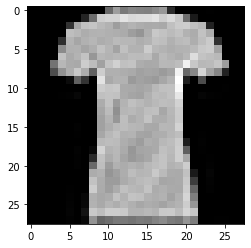

In [24]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

**模型设计**  
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构  
模型构建完成后，将模型放到GPU上用于训练  


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

**设定损失函数**  
使用torch.nn模块自带的CrossEntropy损失  
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss  
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [26]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

In [27]:
?nn.CrossEntropyLoss # 这里方便看一下weighting等策略

Object `nn.CrossEntropyLoss # 这里方便看一下weighting等策略` not found.


**设定优化器**  
这里我们使用Adam优化器  

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**训练和测试（验证）**  
各自封装成函数，方便后续调用  
关注两者的主要区别：  
- 模型状态设置  
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer  
  
此外，对于测试或验证过程，可以计算分类准确率

In [29]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [30]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [31]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.662369
Epoch: 1 	Validation Loss: 0.477593, Accuracy: 0.828900
Epoch: 2 	Training Loss: 0.417999
Epoch: 2 	Validation Loss: 0.370970, Accuracy: 0.867000
Epoch: 3 	Training Loss: 0.355562
Epoch: 3 	Validation Loss: 0.321757, Accuracy: 0.884700
Epoch: 4 	Training Loss: 0.323759
Epoch: 4 	Validation Loss: 0.305721, Accuracy: 0.889700
Epoch: 5 	Training Loss: 0.301573
Epoch: 5 	Validation Loss: 0.299675, Accuracy: 0.890300
Epoch: 6 	Training Loss: 0.287032
Epoch: 6 	Validation Loss: 0.275260, Accuracy: 0.901600
Epoch: 7 	Training Loss: 0.267980
Epoch: 7 	Validation Loss: 0.270146, Accuracy: 0.903000
Epoch: 8 	Training Loss: 0.256404
Epoch: 8 	Validation Loss: 0.268620, Accuracy: 0.899900
Epoch: 9 	Training Loss: 0.252732
Epoch: 9 	Validation Loss: 0.268241, Accuracy: 0.898800
Epoch: 10 	Training Loss: 0.240475
Epoch: 10 	Validation Loss: 0.249730, Accuracy: 0.908700
Epoch: 11 	Training Loss: 0.232593
Epoch: 11 	Validation Loss: 0.241084, Accuracy: 0.912400
Epoch:

**模型保存**  
训练完成后，可以使用torch.save保存模型参数或者整个模型，也可以在训练过程中保存模型  
这部分会在后面的课程中详细介绍

In [32]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)